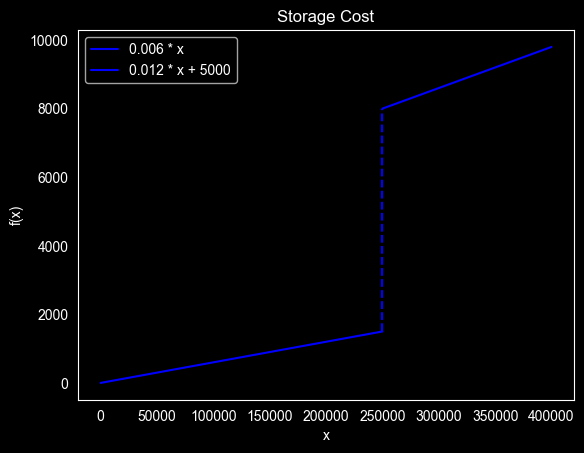

In [250]:
import matplotlib.pyplot as plt
import numpy as np


def storage_cost(x):
    if x < 0:
        return 0
    elif x < 250e3:
        return 0.006 * x
    else:
        return 0.012 * x + 5000


x1 = np.linspace(0, 250e3 - 1, 400)
x2 = np.linspace(250e3, 400e3, 400)
y1 = [storage_cost(xi) for xi in x1]
y2 = [storage_cost(xi) for xi in x2]
plt.style.use("dark_background")
plt.plot(x1, y1, label="0.006 * x", color="blue")
plt.plot(x2, y2, label="0.012 * x + 5000", color="blue")
plt.plot([250e3, 250e3], [storage_cost(250e3 - 1), storage_cost(250e3)], linestyle='dashed', color='blue')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Storage Cost")
plt.legend()
plt.grid()
plt.savefig("../docs/images/storage_cost.png", format="png", transparent=True)


In [251]:
def expected_storage_cost(e, sd_pct, threshold):
    sd = e * sd_pct  # Compute standard deviation
    z = (threshold - e) / sd  # Compute z-score
    Phi_z = norm.cdf(z)  # Probability of being below threshold
    one_minus_Phi_z = 1 - Phi_z  # Probability of being above threshold
    phi_z = norm.pdf(z)  # PDF at z

    # Compute expected values given truncation
    E_X_below = e - sd * (phi_z / Phi_z) if Phi_z > 0 else e  # Avoid division by zero
    E_X_above = e + sd * (phi_z / one_minus_Phi_z) if one_minus_Phi_z > 0 else e

    # Compute expected storage cost
    return (0.006 * E_X_below * Phi_z) + ((5000 + 0.012 * E_X_above) * one_minus_Phi_z)

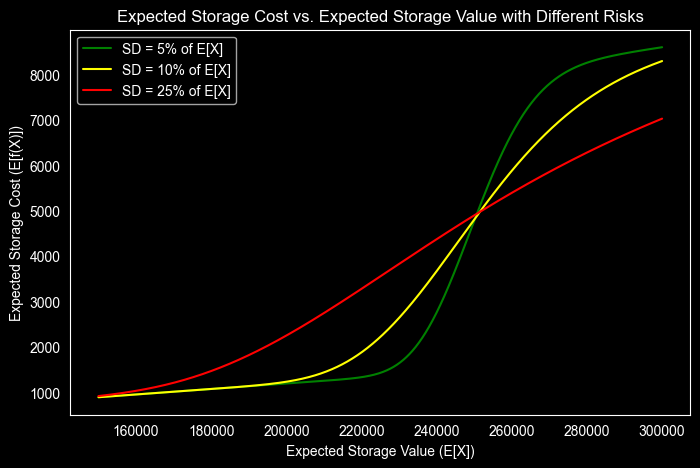

In [252]:


expected_values = np.linspace(150e3, 300e3, 1_000)
sd_percentages = [0.05, 0.10, 0.25]  # Standard deviation as percentage of expected_storage
threshold = 250000  # Threshold value for storage cost
storage_costs = {sd_pct: [] for sd_pct in sd_percentages}

# Compute expected storage costs for each expected value and standard deviation
for e in expected_values:
    for sd_pct in sd_percentages:
        storage_costs[sd_pct].append(expected_storage_cost(e, sd_pct, threshold))

colors = {0.05: "green", 0.10: "yellow", 0.25: "red"}

# Plot results
plt.figure(figsize=(8, 5))
for sd_pct in sd_percentages:
    plt.plot(expected_values, storage_costs[sd_pct], color=colors[sd_pct], label=f"SD = {int(sd_pct * 100)}% of E[X]")
plt.style.use("dark_background")
plt.xlabel("Expected Storage Value (E[X])")
plt.ylabel("Expected Storage Cost (E[f(X)])")
plt.title("Expected Storage Cost vs. Expected Storage Value with Different Risks")
plt.legend()
plt.grid()
plt.show()

In [253]:
import numpy as np

# Beispiel-Datenpunkte
SV_vals = np.linspace(1, 400_000, 10_000)
costs = np.array([expected_storage_cost(sv, sd_pct=0.15, threshold=250_000) for sv in SV_vals])

# Polynomfit (Grad 3)
poly_coefs = np.polyfit(SV_vals, costs, 3)


def fmt(c):
    return f"{c:.2e}" if abs(c) < 1e-3 else f"{c:.6f}"


print(" + ".join([f"{fmt(coef)} * x^{3 - i}" for i, coef in enumerate(poly_coefs)]))


-4.03e-13 * x^3 + 3.19e-07 * x^2 + -0.040267 * x^1 + 1193.322812 * x^0


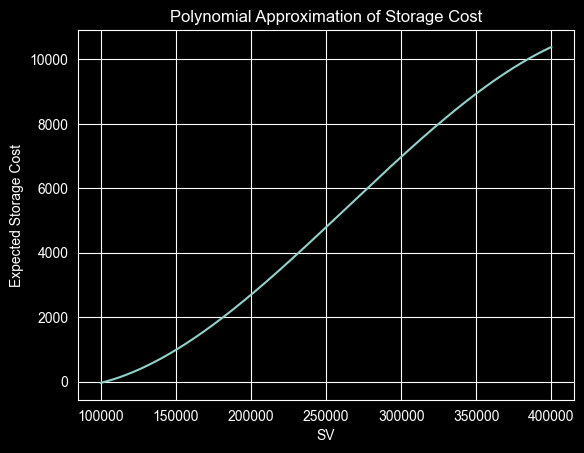

In [254]:
p = np.poly1d(poly_coefs)

x = np.linspace(100_000, 400_000, 500)
y = p(x)

plt.plot(x, y)
plt.xlabel("SV")
plt.ylabel("Expected Storage Cost")
plt.title("Polynomial Approximation of Storage Cost")
plt.show()

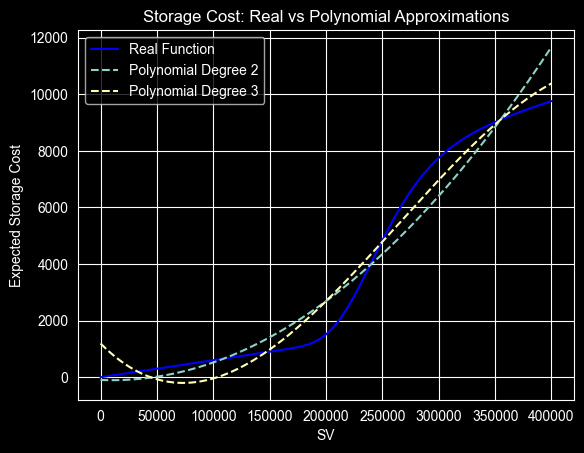

In [255]:
# 2nd‑degree Fit
poly2_coefs = np.polyfit(SV_vals, costs, 2)
p2 = np.poly1d(poly2_coefs)

# 3rd‑degree Fit (for comparison)
poly3_coefs = np.polyfit(SV_vals, costs, 3)
p3 = np.poly1d(poly3_coefs)

# Plot
plt.plot(SV_vals, costs, label="Real Function", color="blue")
plt.plot(SV_vals, p2(SV_vals), label="Polynomial Degree 2", linestyle="--")
plt.plot(SV_vals, p3(SV_vals), label="Polynomial Degree 3", linestyle="--")
plt.xlabel("SV")
plt.ylabel("Expected Storage Cost")
plt.title("Storage Cost: Real vs Polynomial Approximations")
plt.legend()
plt.show()


In [256]:
def fmt(c):
    return f"{c:.2e}" if abs(c) < 1e-3 else f"{c:.4f}"


def format_poly(coefs):
    return " + ".join([f"{fmt(coef)} * x^{len(coefs) - 1 - i}" for i, coef in enumerate(coefs)])


print(format_poly(poly3_coefs))

-4.03e-13 * x^3 + 3.19e-07 * x^2 + -0.0403 * x^1 + 1193.3228 * x^0


In [257]:
poly2_coefs[2] = 0
poly2_coefs[1] = 0
poly2_coefs[0] = 6e-8

In [258]:
print(format_poly(poly2_coefs))


6.00e-08 * x^2 + 0.00e+00 * x^1 + 0.00e+00 * x^0


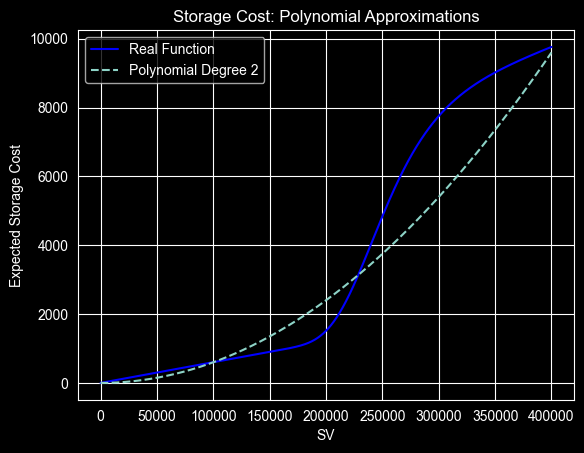

In [259]:
# Plot
p2 = np.poly1d(poly2_coefs)
plt.plot(SV_vals, costs, label="Real Function", color="blue")
plt.plot(SV_vals, p2(SV_vals), label="Polynomial Degree 2", linestyle="--")
plt.xlabel("SV")
plt.ylabel("Expected Storage Cost")
plt.title("Storage Cost: Polynomial Approximations")
plt.legend()
plt.show()

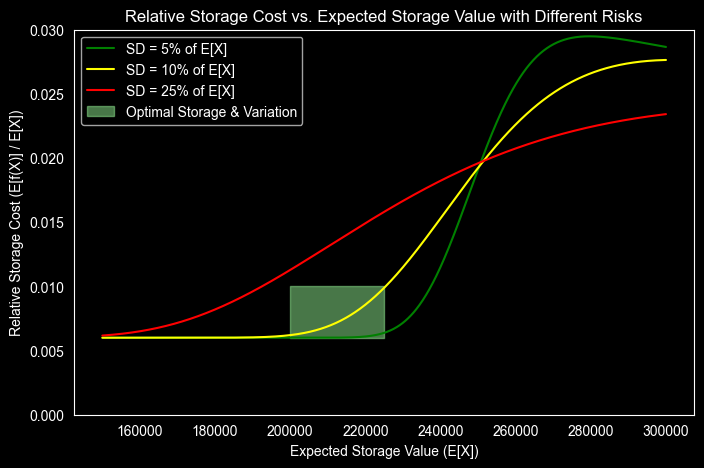

In [260]:
# Compute relative storage cost s(x) / x for each expected value and standard deviation
relative_storage_costs = {sd_pct: np.array(storage_costs[sd_pct]) / expected_values for sd_pct in sd_percentages}
goal_min, goal_max = 200000, 225000
goal_range = (expected_values >= goal_min) & (expected_values <= goal_max)

# Plot relative storage costs
plt.figure(figsize=(8, 5))
for sd_pct in sd_percentages:
    plt.plot(
        expected_values,
        relative_storage_costs[sd_pct],
        label=f"SD = {int(sd_pct * 100)}% of E[X]",
        color=colors[sd_pct]
    )
plt.fill_between(
    expected_values[goal_range],
    0.01,
    0.006,
    color="lightgreen",
    alpha=0.5,
    label="Optimal Storage & Variation"
)
plt.style.use("dark_background")
plt.xlabel("Expected Storage Value (E[X])")
plt.ylabel("Relative Storage Cost (E[f(X)] / E[X])")
plt.title("Relative Storage Cost vs. Expected Storage Value with Different Risks")
plt.grid()
plt.ylim(0, 0.03)
plt.legend()
plt.savefig("../docs/images/relative_storage_cost_optimal.png", format="png", transparent=True)
plt.show()


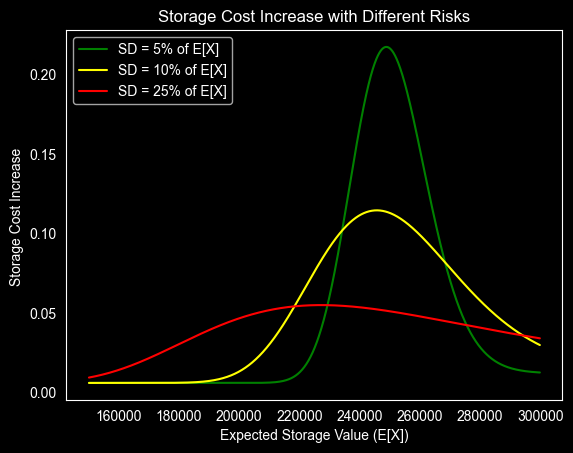

In [261]:
STEP = 100
expected_values = [x for x in range(150_000, 300_000, STEP)]
sd_percentages = [0.05, 0.10, 0.25]  # Standard deviation as percentage of expected_storage
threshold = 250000  # Threshold value for storage cost


def storage_cost_increase(e, sd_pct):
    DIFF = 0.001
    return (expected_storage_cost(e + DIFF, sd_pct, threshold) - expected_storage_cost(e, sd_pct, threshold)) / DIFF


colors = {0.05: "green", 0.10: "yellow", 0.25: "red"}
storage_cost_increase_dict = {sd_pct: [] for sd_pct in sd_percentages}
for sd_pct in sd_percentages:
    for i in range(1, len(expected_values)):
        storage_cost_increase_dict[sd_pct].append(
            storage_cost_increase(expected_values[i], sd_pct)
        )
for sd_pct in sd_percentages:
    plt.plot(
        expected_values[1:],
        storage_cost_increase_dict[sd_pct],
        label=f"SD = {int(sd_pct * 100)}% of E[X]",
        color=colors[sd_pct]
    )

plt.style.use("dark_background")
plt.xlabel("Expected Storage Value (E[X])")
plt.ylabel("Storage Cost Increase ")
plt.title("Storage Cost Increase with Different Risks")
plt.legend()
plt.grid()
plt.savefig("../docs/images/storage_cost_increase.png", format="png", transparent=True)
plt.show()

In [262]:
from scipy.optimize import root_scalar


def find_standard_deviation(e_cost, e, MAX_COST, bracket=(1e-6, 10)):
    def f(sd):
        return e_cost(e, sd) - MAX_COST

    try:
        return root_scalar(f, bracket=bracket).root
    except ValueError:
        return None


xs = np.linspace(220e3, 255e3, 1000)

sds = [find_standard_deviation(storage_cost_increase, x, 0.01) for x in xs]

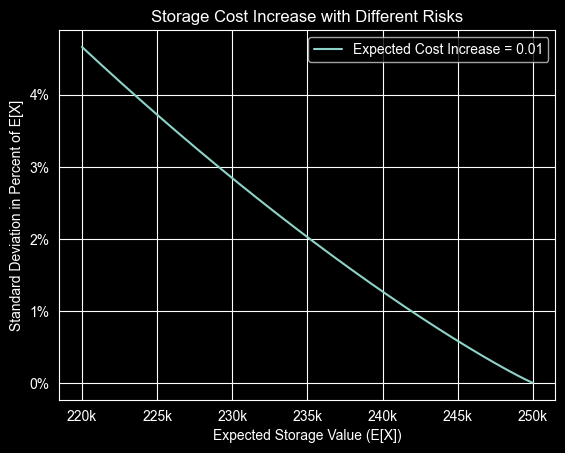

In [263]:
plt.style.use("dark_background")
fig, ax = plt.subplots()

ax.plot(xs, sds, label="Expected Cost Increase = 0.01")
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{int(x / 1000)}k"))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f"{y * 100:.0f}%"))

ax.set_xlabel("Expected Storage Value (E[X])")
ax.set_ylabel("Standard Deviation in Percent of E[X]")
ax.set_title("Storage Cost Increase with Different Risks")
ax.legend()

plt.show()

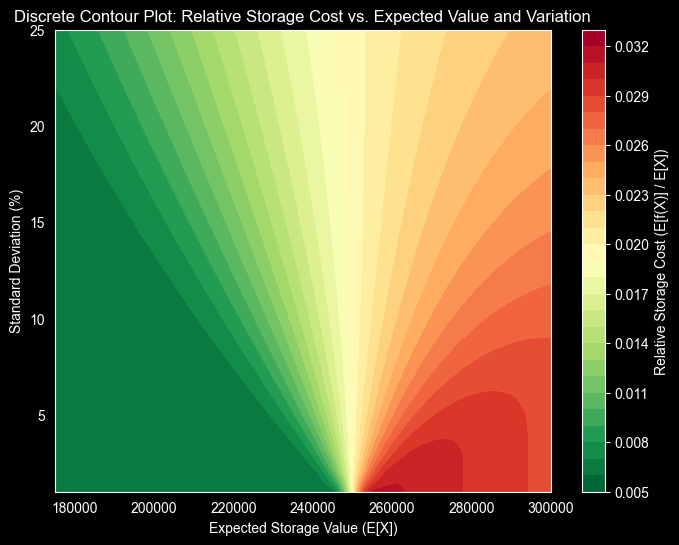

In [264]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1) SETUP
expected_values = np.linspace(175e3, 300e3, 10_000)  # Expected storage values
sd_percentages = [x / 100 for x in range(1, 26)]
threshold = 250000  # Threshold value for storage cost

# Create meshgrid for expected values (X-axis) and SD percentages (Y-axis)
E_mesh, sd_pct_mesh = np.meshgrid(expected_values, sd_percentages)

# 2) CALCULATE EXPECTED STORAGE COSTS FOR EACH POINT
storage_costs_mesh = np.zeros_like(E_mesh)
for i in range(E_mesh.shape[0]):
    for j in range(E_mesh.shape[1]):
        e = E_mesh[i, j]
        sd = e * sd_pct_mesh[i, j]  # Standard deviation
        z = (threshold - e) / sd  # z-score
        Phi_z = norm.cdf(z)  # Probability of X < threshold
        one_minus_Phi_z = 1 - Phi_z
        phi_z = norm.pdf(z)

        # Avoid division by zero
        E_X_below = e - sd * (phi_z / Phi_z) if Phi_z > 0 else e
        E_X_above = e + sd * (phi_z / one_minus_Phi_z) if one_minus_Phi_z > 0 else e

        # Expected storage cost
        storage_costs_mesh[i, j] = (
                0.006 * E_X_below * Phi_z
                + (5000 + 0.012 * E_X_above) * one_minus_Phi_z
        )

# 3) RELATIVE STORAGE COST = s(x) / x
relative_cost_mesh = storage_costs_mesh / E_mesh

# 4) DEFINE DISCRETE LEVELS FOR THE CONTOUR
levels = [x / 1000 for x in range(5, 34, 1)]

# 5) CREATE A DISCRETE COLORMAP (GREEN → YELLOW → RED), WITH EXTENDED BOUNDS Red Yellow Green Reversed
cmap = plt.get_cmap("RdYlGn_r", len(levels) - 1)

# 6) PLOT THE CONTOUR WITH FEWER, DISCRETE COLORS
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(
    E_mesh,
    sd_pct_mesh * 100,
    relative_cost_mesh,
    levels=levels,
    cmap=cmap,
)
# 7) COLOR BAR & LABELS
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label("Relative Storage Cost (E[f(X)] / E[X])")
ax.set_xlabel("Expected Storage Value (E[X])")
ax.set_ylabel("Standard Deviation (%)")
ax.set_title("Discrete Contour Plot: Relative Storage Cost vs. Expected Value and Variation")
plt.style.use("dark_background")
plt.savefig("../docs/images/color_map_standard_deviation_expected_optimal_large.png", format="png", transparent=True)

plt.show()

print()


In [265]:
def storage_cost(expected_storage, standard_deviation_relative, threshold):
    standard_deviation = expected_storage * standard_deviation_relative
    z = (threshold - expected_storage) / standard_deviation
    Phi_z = norm.cdf(z)
    one_minus_phi_z = 1 - Phi_z
    phi_z = norm.pdf(z)

    e_x_below = expected_storage - standard_deviation * (phi_z / Phi_z) if phi_z > 0 else expected_storage
    e_x_above = expected_storage + standard_deviation * (
            phi_z / one_minus_phi_z) if one_minus_phi_z > 0 else expected_storage

    return (0.006 * e_x_below * Phi_z) + ((5000 + 0.012 * e_x_above) * one_minus_phi_z)

In [266]:
import pandas as pd

df = pd.read_csv(r"C:\Users\bueck\PycharmProjects\ibsys2SCM\user-docs\data_analyses\labour-machine-cost.csv",
                 decimal=",")

In [267]:
import dataclasses

MINIMUM_SHIFTS = 1
MAXIMUM_SHIFTS = 3
SHIFT_DURATION = 60 * 8
MAX_OVERTIME = SHIFT_DURATION / 2
MAX_DURATION = SHIFT_DURATION * 3


def round_ties_to_down(number):
    return round(number - 0.00001)


@dataclasses.dataclass
class CalculateShiftCost:
    labour_cost_1: float
    labour_cost_2: float
    labour_cost_3: float
    labour_overtime_cost: float
    fix_machine_cost: float
    var_machine_cost: float

    def calculate_required_shifts(self, required_capacity):
        rounded_shift = round_ties_to_down(required_capacity / SHIFT_DURATION)
        shifts = max(MINIMUM_SHIFTS, min(MAXIMUM_SHIFTS, rounded_shift))
        return shifts

    def calculate_overtime(self, required_capacity):
        shifts = self.calculate_required_shifts(required_capacity)
        if shifts == 3:
            return 0
        else:
            return max(0, required_capacity - shifts * SHIFT_DURATION)

    def calc_labour_cost(self, required_capacity):
        shifts = self.calculate_required_shifts(required_capacity)
        overtime = self.calculate_overtime(required_capacity)
        first_shift_cost = float(SHIFT_DURATION * self.labour_cost_1)
        second_shift_cost = float(SHIFT_DURATION * self.labour_cost_2)
        third_shift_cost = float(SHIFT_DURATION * self.labour_cost_3)

        overtime_cost = float(overtime * self.labour_overtime_cost)

        labour_cost = first_shift_cost + overtime_cost

        match shifts:
            case 2:
                labour_cost += second_shift_cost
            case 3:
                labour_cost += second_shift_cost + third_shift_cost

        return labour_cost

    def calc_labour_cost_relative(self, required_capacity):
        labour_cost_abs = self.calc_labour_cost(required_capacity)
        return labour_cost_abs / required_capacity

    def calculate_fix_machine_cost(self, required_capacity):
        shifts = self.calculate_required_shifts(required_capacity)
        overtime = self.calculate_overtime(required_capacity)

        work_time = shifts * SHIFT_DURATION + overtime

        idle_time = work_time - required_capacity

        return self.fix_machine_cost * idle_time

    def calculate_fix_machine_cost_relative(self, required_capacity):
        fix_machine_cost = self.calculate_fix_machine_cost(required_capacity)
        return fix_machine_cost / required_capacity

    def calculate_var_machine_cost(self, required_capacity):
        return self.var_machine_cost * required_capacity

    def calculate_var_machine_cost_relative(self, required_capacity):
        var_machine_cost = self.calculate_var_machine_cost(required_capacity)
        return var_machine_cost / required_capacity

    def calc_abs_cost(self, required_capacity):
        return self.calc_labour_cost(required_capacity) + self.calculate_fix_machine_cost(
            required_capacity) + self.calculate_var_machine_cost(required_capacity)


first_ws = df[df["workstation"] == 1]


def get_cost_calc_from(ws_num):
    ws = df[df["workstation"] == ws_num]
    return CalculateShiftCost(
        ws["labourCost1"].iloc[0],
        ws["labourCost2"].iloc[0],
        ws["labourCost3"].iloc[0],
        ws["labourOvertimeCost"].iloc[0],
        ws["var_machineCost"].iloc[0],
        ws["fix_machineCost"].iloc[0]
    )


cost_calc_1 = get_cost_calc_from(1)
cost_calc_9 = get_cost_calc_from(9)


In [268]:
assert cost_calc_1.calculate_required_shifts(400) == 1
assert cost_calc_1.calculate_required_shifts(700) == 1
assert cost_calc_1.calculate_required_shifts(720) == 1
assert cost_calc_1.calculate_required_shifts(721) == 2
assert cost_calc_1.calculate_required_shifts(1000) == 2
assert cost_calc_1.calculate_required_shifts(10_000) == 3

In [269]:
cost_calc_1.calc_labour_cost(400)

216.0

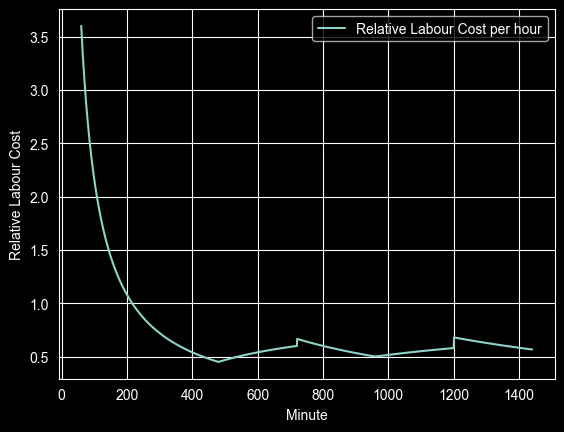

In [270]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(60, 60 * 24 + 1)
y = [cost_calc_1.calc_labour_cost_relative(i) for i in x]

plt.plot(x, y, label="Relative Labour Cost per hour")
plt.xlabel("Minute")
plt.ylabel("Relative Labour Cost")
plt.legend()
plt.show()


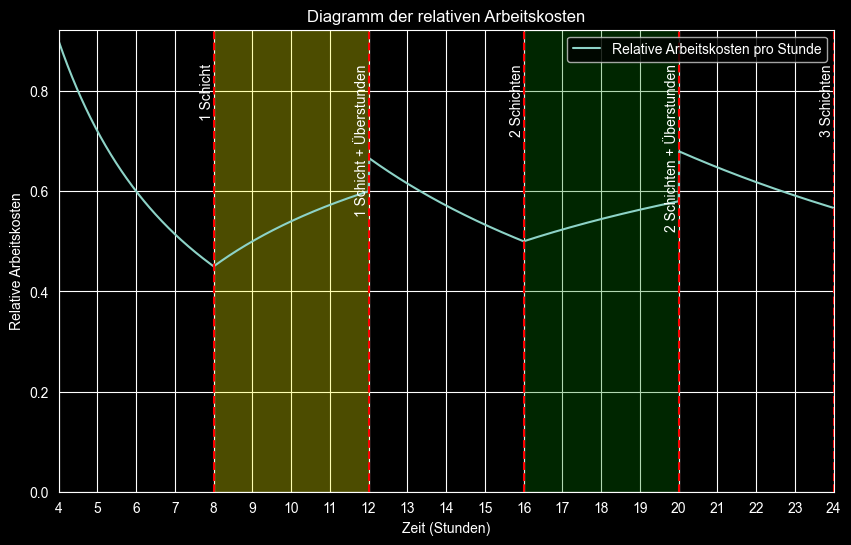

In [271]:
import matplotlib.pyplot as plt
import numpy as np

FIRST_VALUE = 60 * 4

x = np.arange(FIRST_VALUE, 60 * 24 + 1)
y = [cost_calc_1.calc_labour_cost_relative(i) for i in x]

plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Relative Arbeitskosten pro Stunde")
plt.xlabel("Zeit (Stunden)")
plt.ylabel("Relative Arbeitskosten")
plt.title("Diagramm der relativen Arbeitskosten")
plt.ylim(bottom=0)

# Markiere spezielle Bereiche:
plt.axvspan(8 * 60, 12 * 60, facecolor='yellow', alpha=0.3)  # Bereich: 1 Schicht bis 1 Schicht + Überstunden
plt.axvspan(16 * 60, 20 * 60, facecolor='green', alpha=0.3)  # Bereich: 2 Schichten bis 2 Schichten + Überstunden

shift_positions = {
    8 * 60: "1 Schicht",
    12 * 60: "1 Schicht + Überstunden",
    16 * 60: "2 Schichten",
    20 * 60: "2 Schichten + Überstunden",
    24 * 60: "3 Schichten"
}

y_max = max(y)
for pos, lab in shift_positions.items():
    plt.axvline(x=pos, color="red", linestyle="--")
    plt.text(pos, y_max * 0.95, lab, rotation=90, verticalalignment="top", horizontalalignment="right")

plt.xlim(FIRST_VALUE, 60 * 24)
ticks = np.arange(FIRST_VALUE, 60 * 24 + 1, 60)
plt.xticks(ticks, [str(int(tick / 60)) for tick in ticks])
plt.legend()
plt.savefig("../docs/images/simple_relative_labour_cost.png", format="png", transparent=True)

plt.show()


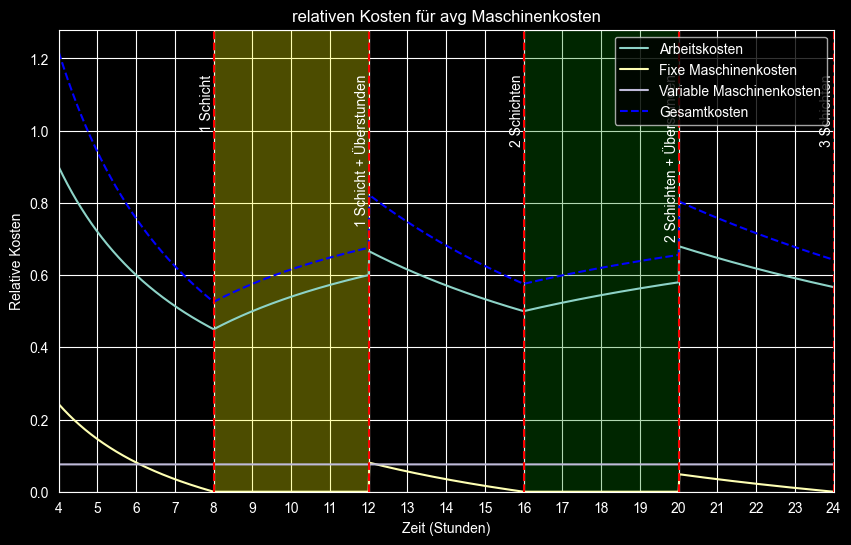

In [272]:
import matplotlib.pyplot as plt
import numpy as np


def plot_ws_costs(cost_calc, title, filename):
    FIRST_VALUE = 60 * 4

    x = np.arange(FIRST_VALUE, 60 * 24 + 1)
    y_labour = [cost_calc.calc_labour_cost_relative(i) for i in x]
    y_fix = [cost_calc.calculate_fix_machine_cost_relative(i) for i in x]
    y_var = [cost_calc.calculate_var_machine_cost_relative(i) for i in x]
    y_total = [l + f + v for l, f, v in zip(y_labour, y_fix, y_var)]

    plt.figure(figsize=(10, 6))
    plt.plot(x, y_labour, label="Arbeitskosten")
    plt.plot(x, y_fix, label="Fixe Maschinenkosten")
    plt.plot(x, y_var, label="Variable Maschinenkosten")
    plt.plot(x, y_total, c="blue", label="Gesamtkosten", linestyle="--")

    plt.xlabel("Zeit (Stunden)")
    plt.ylabel("Relative Kosten")
    plt.title(title)
    plt.ylim(bottom=0)

    # Markiere spezielle Bereiche:
    plt.axvspan(8 * 60, 12 * 60, facecolor='yellow', alpha=0.3)  # 1 Schicht bis 1 Schicht + Überstunden
    plt.axvspan(16 * 60, 20 * 60, facecolor='green', alpha=0.3)  # 2 Schichten bis 2 Schichten + Überstunden

    shift_positions = {
        8 * 60: "1 Schicht",
        12 * 60: "1 Schicht + Überstunden",
        16 * 60: "2 Schichten",
        20 * 60: "2 Schichten + Überstunden",
        24 * 60: "3 Schichten"
    }

    y_max = max(max(y_labour), max(y_fix), max(y_var), max(y_total))
    for pos, lab in shift_positions.items():
        plt.axvline(x=pos, color="red", linestyle="--")
        plt.text(pos, y_max * 0.95, lab, rotation=90, verticalalignment="top", horizontalalignment="right")

    plt.xlim(FIRST_VALUE, 60 * 24)
    ticks = np.arange(FIRST_VALUE, 60 * 24 + 1, 60)
    plt.xticks(ticks, [str(int(tick / 60)) for tick in ticks])
    plt.legend()
    plt.savefig(f"../docs/images/{filename}", format="png", transparent=True)

    plt.show()


average_row = df.mean()

avg_cost_calc = CalculateShiftCost(
    average_row["labourCost1"],
    average_row["labourCost2"],
    average_row["labourCost3"],
    average_row["labourOvertimeCost"],
    average_row["var_machineCost"],
    average_row["fix_machineCost"]
)
plot_ws_costs(avg_cost_calc, "relativen Kosten für avg Maschinenkosten", "total_relative_cost_avg.png")

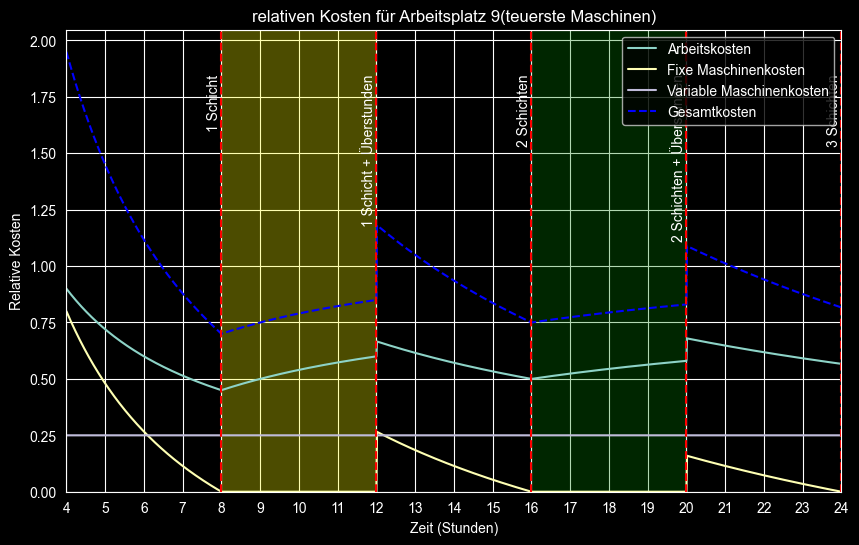

In [273]:
plot_ws_costs(cost_calc_9, "relativen Kosten für Arbeitsplatz 9(teuerste Maschinen)",
              "total_relative_cost_expensive.png")

In [274]:
def plot_ws_costs_abs(cost_calc: CalculateShiftCost, title, filename):
    FIRST_VALUE = 60 * 4

    x = np.arange(FIRST_VALUE, 60 * 24 + 1)
    y_total = [cost_calc.calc_abs_cost(i) for i in x]

    plt.figure(figsize=(10, 6))
    plt.plot(x, y_total, c="blue", label="Gesamtkosten", linestyle="--")

    plt.xlabel("Zeit (Stunden)")
    plt.ylabel("Abs Kosten")
    plt.title(title)
    plt.ylim(bottom=0)

    # Markiere spezielle Bereiche:
    plt.axvspan(8 * 60, 12 * 60, facecolor='yellow', alpha=0.3)  # 1 Schicht bis 1 Schicht + Überstunden
    plt.axvspan(16 * 60, 20 * 60, facecolor='green', alpha=0.3)  # 2 Schichten bis 2 Schichten + Überstunden

    shift_positions = {
        8 * 60: "1 Schicht",
        12 * 60: "1 Schicht + Überstunden",
        16 * 60: "2 Schichten",
        20 * 60: "2 Schichten + Überstunden",
        24 * 60: "3 Schichten"
    }

    y_max = max(y_total)
    for pos, lab in shift_positions.items():
        plt.axvline(x=pos, color="red", linestyle="--")
        plt.text(pos, y_max * 0.95, lab, rotation=90, verticalalignment="top", horizontalalignment="right")

    plt.xlim(FIRST_VALUE, 60 * 24)
    ticks = np.arange(FIRST_VALUE, 60 * 24 + 1, 60)
    plt.xticks(ticks, [str(int(tick / 60)) for tick in ticks])
    plt.legend()
    plt.savefig(f"../docs/images/{filename}", format="png", transparent=True)

    plt.show()

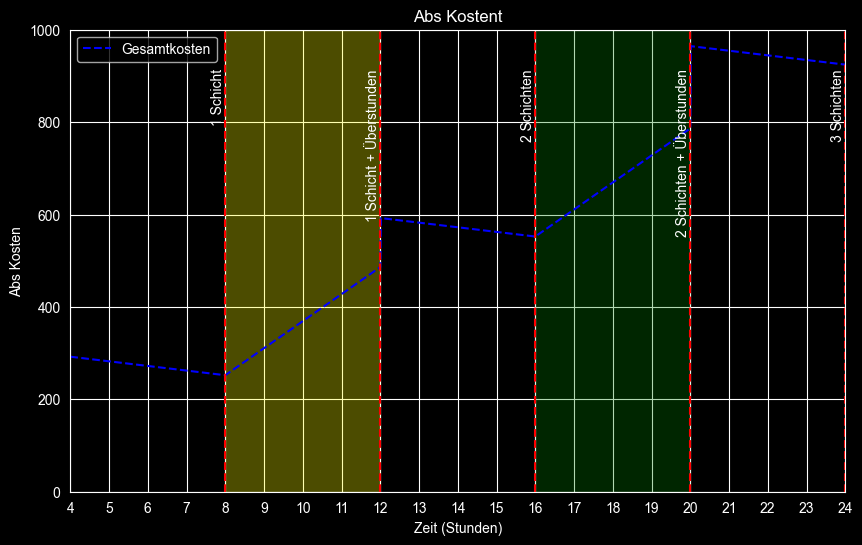

In [278]:
plot_ws_costs_abs(avg_cost_calc, "Abs Kosten", "total_abs_cost_avg.png")

In [276]:
df.head()

,workstation,labourCost1,labourCost2,labourCost3,labourOvertimeCost,var_machineCost,fix_machineCost
0,1,0.45,0.55,0.7,0.9,0.05,0.01
1,2,0.45,0.55,0.7,0.9,0.05,0.01
2,3,0.45,0.55,0.7,0.9,0.05,0.01
3,4,0.45,0.55,0.7,0.9,0.05,0.01
4,6,0.45,0.55,0.7,0.9,0.30,0.10


FileNotFoundError: [Errno 2] No such file or directory: 'docs/images/machine_cost_distribution.png'

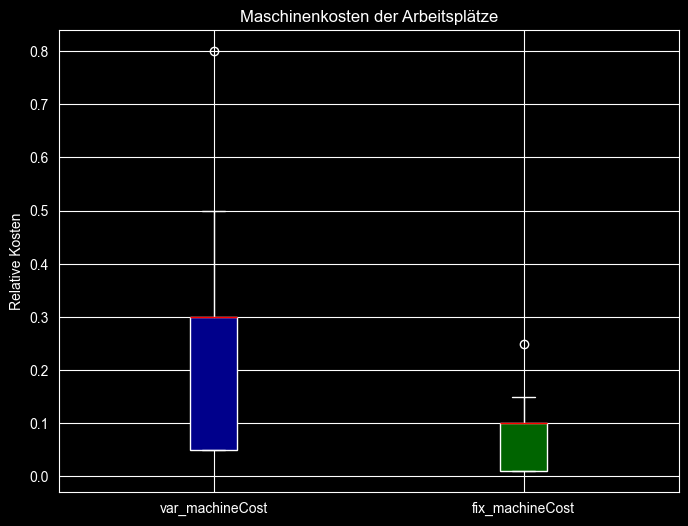

In [277]:
machine_costs = df[["var_machineCost", "fix_machineCost"]]

plt.style.use('dark_background')
plt.figure(figsize=(8, 6))
bp = machine_costs.boxplot(patch_artist=True, return_type='dict')

# Custom colors for dark theme
box_colors = ["darkblue", "darkgreen"]
border_color = "white"
median_color = "red"
whisker_color = "white"
cap_color = "white"
flier_color = "white"

for i, box in enumerate(bp['boxes']):
    box.set_facecolor(box_colors[i])
    box.set_edgecolor(border_color)

for median in bp['medians']:
    median.set_color(median_color)

for whisker in bp['whiskers']:
    whisker.set_color(whisker_color)

for cap in bp['caps']:
    cap.set_color(cap_color)

plt.title("Maschinenkosten der Arbeitsplätze", color="white")
plt.ylabel("Relative Kosten", color="white")
plt.savefig(f"docs/images/machine_cost_distribution.png", format="png", transparent=True)
plt.show()

# Average Machine cost share of total cost

In [157]:
x = np.arange(1, 24 * 60)


def median_machine_cost(cost_calc):
    y_fix = [cost_calc.calculate_fix_machine_cost_relative(i) for i in x]
    y_var = [cost_calc.calculate_var_machine_cost_relative(i) for i in x]
    return np.median([f + v for f, v in zip(y_fix, y_var)])


def median_fix_cost(cost_calc):
    y_fix = [cost_calc.calculate_fix_machine_cost_relative(i) for i in x]
    return np.median(y_fix)


def median_var_cost(cost_calc):
    y_var = [cost_calc.calculate_var_machine_cost_relative(i) for i in x]
    return np.median(y_var)


def median_labour_cost(cost_calc):
    y_labour = [cost_calc.calc_labour_cost_relative(i) for i in x]
    return np.median(y_labour)


def median_total_cost(cost_calc):
    y_labour = [cost_calc.calc_labour_cost_relative(i) for i in x]
    y_fix = [cost_calc.calculate_fix_machine_cost_relative(i) for i in x]
    y_var = [cost_calc.calculate_var_machine_cost_relative(i) for i in x]
    return np.median([l + f + v for l, f, v in zip(y_labour, y_fix, y_var)])


def median_machine_share(cost_calc):
    return median_machine_cost(cost_calc) / median_total_cost(cost_calc)


def plot_pie(cost_calc, file_name):
    median_labour = median_labour_cost(cost_calc)
    median_fix = median_fix_cost(cost_calc)
    median_var = median_var_cost(cost_calc)

    # Erstelle das Kreisdiagramm
    labels = ["Arbeitskosten", "Fixe Maschinenkosten", "Variable Maschinenkosten"]
    sizes = [median_labour, median_fix, median_var]
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    plt.style.use('dark_background')
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct="%1.0f%%", startangle=90, colors=colors)
    plt.title("Median-Kostenanteile", color="white")
    plt.savefig(f"docs/images/{file_name}", format="png", transparent=True)
    plt.show()


print(median_machine_cost(avg_cost_calc))
print(median_total_cost(avg_cost_calc))
print(median_machine_cost(cost_calc_9))
print(median_total_cost(cost_calc_9))

0.09779220779220779
0.6727089337175792
0.32272727272727275
0.8949339207048458


In [158]:
print(f"Median Machine Share of most exensive machine: {median_machine_share(cost_calc_9)}")
print(f"Median Machine Share of average machine: {median_machine_share(avg_cost_calc)}")

Median Machine Share of most exensive machine: 0.3606157563824313
Median Machine Share of average machine: 0.14537075827398407


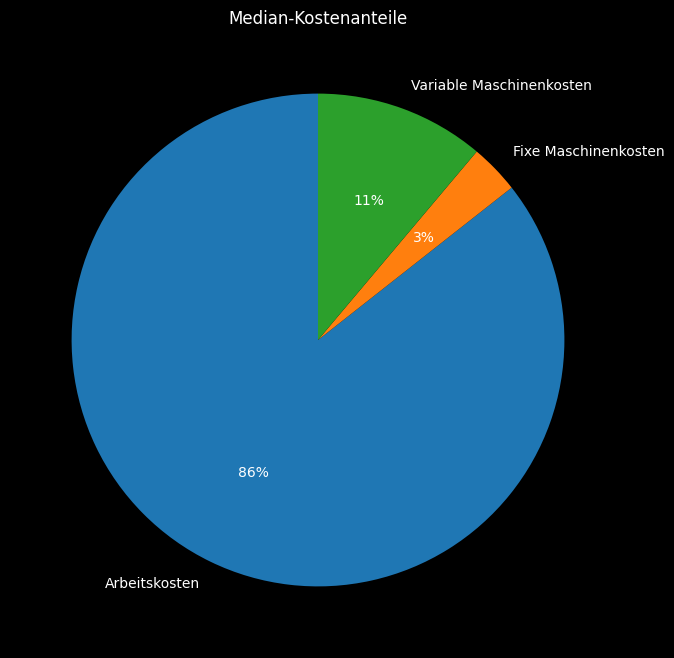

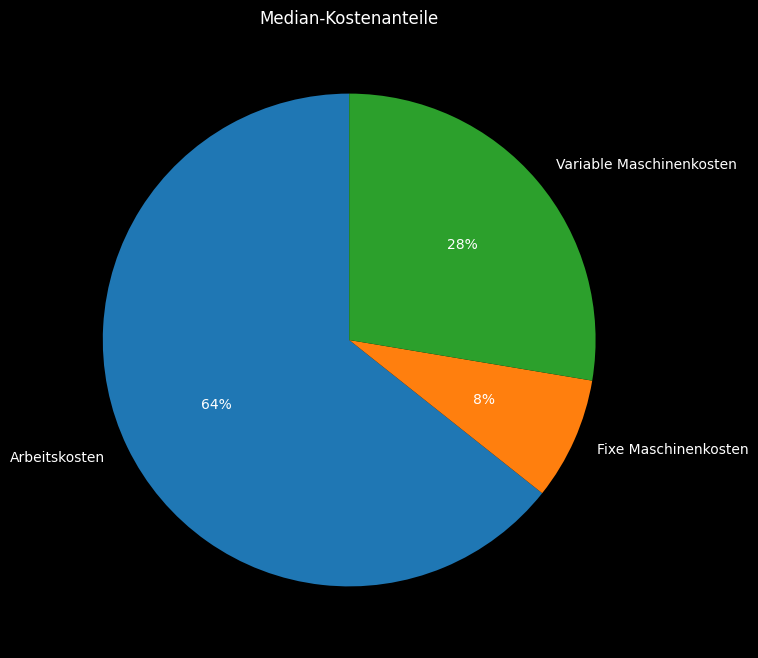

In [159]:
plot_pie(avg_cost_calc, "avg_median_cost_share.png")
plot_pie(cost_calc_9, "most_expensive_median_cost_share.png")


In [160]:
df.head()

,workstation,labourCost1,labourCost2,labourCost3,labourOvertimeCost,var_machineCost,fix_machineCost
0,1,0.45,0.55,0.7,0.9,0.05,0.01
1,2,0.45,0.55,0.7,0.9,0.05,0.01
2,3,0.45,0.55,0.7,0.9,0.05,0.01
3,4,0.45,0.55,0.7,0.9,0.05,0.01
4,6,0.45,0.55,0.7,0.9,0.30,0.10


In [161]:
ratio = df["var_machineCost"] / df["fix_machineCost"]

mean_ratio = ratio.mean()
std_ratio = ratio.std()

print("Mean factor (var / fix):", mean_ratio)
print("Standard deviation:", std_ratio)

Mean factor (var / fix): 3.8952380952380956
Standard deviation: 0.9973346653337759


In [172]:
BASE_SHIFT = 2_400
(df["labourCost1"].sum() + df["fix_machineCost"].sum()) * BASE_SHIFT

np.float64(17664.000000000004)

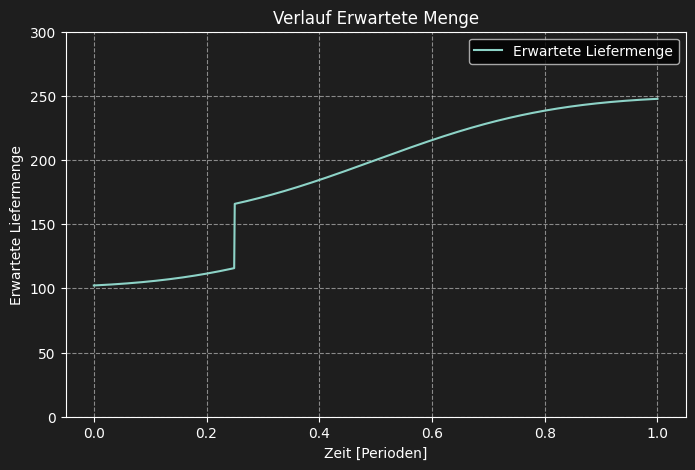

<Figure size 800x500 with 0 Axes>

In [163]:
import numpy as np
import matplotlib.pyplot as plt


@dataclasses.dataclass
class Delivery:
    expected_delivery: float
    standard_deviation: float
    quantity: int

    def calculate_expected_delivery_quantity(self, before_periods: float):
        if self.standard_deviation <= 0.0000001:
            return self.quantity if before_periods >= self.expected_delivery else 0
        probability = norm.cdf(before_periods, loc=self.expected_delivery, scale=self.standard_deviation)
        return self.quantity * probability


initial_delivery = Delivery(0, 0, 100)
normal_delivery = Delivery(0.5, 0.25, 100)
fast_delivery = Delivery(0.25, 0, 50)
DELIVERIES = [
    initial_delivery,
    normal_delivery,
    fast_delivery
]


def sum_expected_delivery(before_periods, deliveries):
    return sum([delivery.calculate_expected_delivery_quantity(before_periods) for delivery in deliveries])


xs = np.arange(0.0001, 1.001, 0.001)
fig, ax = plt.subplots(figsize=(8, 5))

# Set background color to dark gray
fig.patch.set_facecolor("#1E1E1E")  # Dark gray background
ax.set_facecolor("#1E1E1E")  # Same for axes
# Compute y values
ys = [sum_expected_delivery(x, DELIVERIES) for x in xs]
plt.style.use("dark_background")
# Create the plot
plt.figure(figsize=(8, 5))
ax.plot(xs, ys, label="Erwartete Liefermenge")
ax.set_ylim(0, 300)
ax.set_xlabel("Zeit [Perioden]")
ax.set_ylabel("Erwartete Liefermenge")
ax.set_title("Verlauf Erwartete Menge")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.6, color="lightgray")  # Light gray grid

# Show the plot
plt.show()

In [164]:
MAX_USE_PER_PERIOD = 200

In [165]:
def plot_inventory_diagram(deliveries, usage_rate):
    STEP = 0.001
    xs = np.arange(STEP, 1, STEP)

    # Compute expected delivery at each x
    ys = [sum_expected_delivery(x, deliveries) for x in xs]

    # Compute actual available inventory considering usage
    actual_inventory = []
    remaining_inventory = sum_expected_delivery(0, deliveries)  # Initial inventory

    for x in xs:
        # Additional expected inventory between the previous and current step
        expected_increase = (
                sum_expected_delivery(x, deliveries)
                - sum_expected_delivery(x - STEP, deliveries)
        )
        remaining_inventory += expected_increase

        # Usage in the current step
        used = min(remaining_inventory, usage_rate * STEP)
        remaining_inventory -= used
        actual_inventory.append(remaining_inventory)

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 5))
    fig.patch.set_facecolor("#1E1E1E")
    ax.set_facecolor("#1E1E1E")

    # Plot the expected inventory
    ax.plot(xs, ys, label="Erwartete Liefermenge", color="cyan")

    # Plot the actual available inventory
    ax.plot(xs, actual_inventory, label="Tatsächlich Verfügbare Menge",
            color="red", linestyle="dashed")

    # Add a vertical line for each delivery’s expected delivery time
    for i, d in enumerate(deliveries):
        # Draw the vertical line
        ax.axvline(d.expected_delivery, color="white", linestyle="--", alpha=0.7)

        # Annotate with quantity and std dev, slightly offset in x
        annotation = f"Q: {d.quantity}, SD: {d.standard_deviation}"
        ax.text(
            d.expected_delivery + 0.01,  # shift a bit to the right
            280 - i * 20,  # place at different heights
            annotation,
            color="white",
            bbox=dict(boxstyle="round", facecolor="#2E2E2E", alpha=0.8)
        )

    # Configure axes and labels
    ax.set_ylim(0, 300)
    ax.set_xlabel("Zeit [Perioden]", color="white")
    ax.set_ylabel("Menge", color="white")
    ax.set_title("Verlauf Erwartete vs. Tatsächliche Menge", color="white")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6, color="lightgray")

    plt.show()


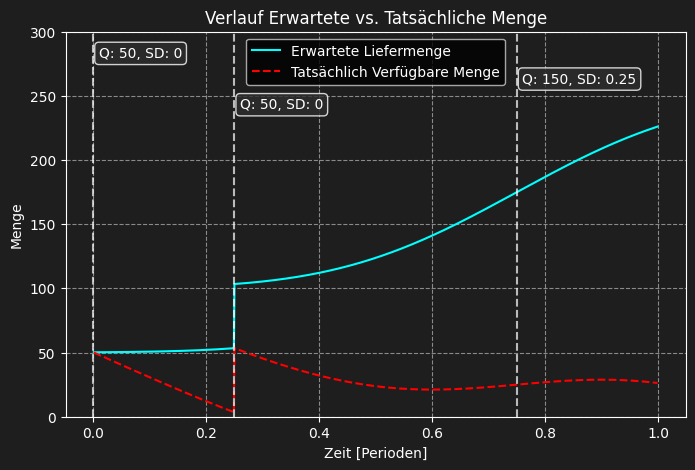

In [166]:
# Define the usage per period
USAGE_RATE = 200  # The manufacturer uses 200 units per period

initial_delivery = Delivery(0, 0, 50)
normal_delivery = Delivery(0.75, 0.25, 150)
fast_delivery = Delivery(0.25, 0, 50)
deliveries = [
    initial_delivery,
    normal_delivery,
    fast_delivery
]
plot_inventory_diagram(deliveries, USAGE_RATE)

In [167]:
import itertools
from scipy.stats import norm


def risk_at_time(T, deliveries, usage_rate):
    # Total consumption until time T
    consumption = usage_rate * T

    risk = 0
    n = len(deliveries)
    # Enumerate all possible outcomes (each outcome: a tuple of booleans for delivered or not)
    for outcome in itertools.product([0, 1], repeat=n):
        # delivered_sum: sum of delivered quantities when outcome[i]==1
        delivered_sum = sum(d.quantity for d, delivered in zip(deliveries, outcome) if delivered)
        # probability of this outcome:
        prob = 1
        for d, delivered in zip(deliveries, outcome):
            p = norm.cdf(T, loc=d.expected_delivery, scale=d.standard_deviation) if d.standard_deviation > 1e-8 else (
                1 if T >= d.expected_delivery else 0)
            prob *= p if delivered else (1 - p)
        # If the delivered sum is less than consumption, add this outcome's probability to risk.
        if delivered_sum < consumption:
            risk += prob
    return risk


T = 1.0  # for instance, at period 1.0
usage_rate = 200
print("Risk at time T =", T, "is", risk_at_time(T, DELIVERIES, usage_rate))


Risk at time T = 1.0 is 0.02275013194817921


In [168]:
import numpy as np


def risk_during_interval(Ta, Tb, deliveries, usage_rate, dt=0.001, num_simulations=10000):
    times = np.arange(Ta, Tb + dt, dt)
    empty_count = 0

    # For each simulation, generate random arrival times for each delivery.
    # Assume that delivery i arrives at a time drawn from N(mu, sigma) (or deterministically if sigma==0).
    for _ in range(num_simulations):
        # For each delivery, sample arrival time (if sigma is 0, then use expected_delivery)
        arrival_times = [d.expected_delivery if d.standard_deviation < 1e-8 else np.random.normal(d.expected_delivery,
                                                                                                  d.standard_deviation)
                         for d in deliveries]
        # Assume delivery is only useful if it arrives before current time.
        inventory = 0
        empty_during_interval = False
        for t in times:
            # Increase inventory with deliveries arriving exactly at time t (if arrival time <= t)
            for d, arrival in zip(deliveries, arrival_times):
                if t - dt < arrival <= t:
                    inventory += d.quantity
            # Subtract usage (usage_rate per period, dt step)
            inventory -= usage_rate * dt
            if inventory < 0:
                empty_during_interval = True
                break
        if empty_during_interval:
            empty_count += 1

    return empty_count / num_simulations


# Example usage:
Ta = 0
Tb = 1
print("Risk during [", Ta, ",", Tb, "] is", risk_during_interval(Ta, Tb, DELIVERIES, USAGE_RATE))

Risk during [ 0 , 1 ] is 0.1831


In [169]:
def plot_inventory_diagram_with_risk(deliveries, usage_rate, file_name):
    STEP = 0.001
    xs = np.arange(STEP, 1, STEP)

    # Compute expected delivery at each x
    ys = [sum_expected_delivery(x, deliveries) for x in xs]
    risks = [risk_at_time(x, deliveries, usage_rate) for x in xs]

    # Compute actual available inventory considering usage
    actual_inventory = []
    remaining_inventory = sum_expected_delivery(0, deliveries)  # Initial inventory

    for x in xs:
        # Additional expected inventory between the previous and current step
        expected_increase = (
                sum_expected_delivery(x, deliveries)
                - sum_expected_delivery(x - STEP, deliveries)
        )
        remaining_inventory += expected_increase

        # Usage in the current step
        used = min(remaining_inventory, usage_rate * STEP)
        remaining_inventory -= used
        actual_inventory.append(remaining_inventory)

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 5))
    fig.patch.set_facecolor("#1E1E1E")
    ax.set_facecolor("#1E1E1E")

    # Plot the expected inventory
    ax.plot(xs, ys, label="Erwartete Liefermenge", color="cyan")

    # Plot the actual available inventory
    ax.plot(xs, actual_inventory, label="Erwartete Lagermenge",
            color="orange", linestyle="dashed")

    # Plot the risk
    ax2 = ax.twinx()
    ax2.plot(xs, risks, color="red", label="Risiko d. Ausverkaufs")

    # Add a vertical line for each delivery’s expected delivery time
    for i, d in enumerate(deliveries):
        # Draw the vertical line
        ax.axvline(d.expected_delivery, color="white", linestyle="--", alpha=0.7)

        # Annotate with quantity and std dev, slightly offset in x
        annotation = f"Q: {d.quantity}, SD: {d.standard_deviation}"
        ax.text(
            d.expected_delivery + 0.01,  # shift a bit to the right
            280 - i * 20,  # place at different heights
            annotation,
            color="white",
            bbox=dict(boxstyle="round", facecolor="#2E2E2E", alpha=0.8)
        )

    # Configure axes and labels
    ax.set_ylim(0, 300)
    ax.set_xlabel("Zeit [Perioden]", color="white")
    ax2.set_ylabel("Risiko des Ausverkaufs[1=100%]")
    ax.set_ylabel("Menge", color="white")
    ax.set_title("Bestell Optimierung", color="white")
    ax.legend()
    ax2.legend()
    ax.grid(True, linestyle="--", alpha=0.6, color="lightgray")
    plt.savefig(f"docs/images/{file_name}", format="png", transparent=True)
    plt.show()


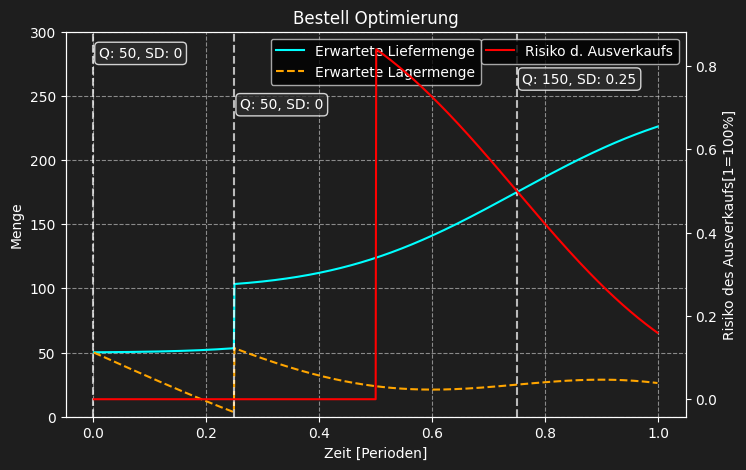

In [170]:
plot_inventory_diagram_with_risk(deliveries, USAGE_RATE, "empty_storage_risk.png")